In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
import numpy as np
import matplotlib.pyplot as plt
import time
import random

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

1

In [4]:
torch.cuda.get_device_name(0)

'Quadro RTX 6000'

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
train_ds_normalized = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
        )
train_ds_unnormalized = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),]))

In [6]:
batch_size = 200
# train_loader = torch.utils.data.DataLoader(
#     train_ds_normalized, batch_size=batch_size, shuffle=True,
# )
train_loader = torch.utils.data.DataLoader(train_ds_unnormalized, shuffle=True, batch_size=batch_size)

shape_nor = torch.Size([6000, 1, 28, 28])
shape_unn = torch.Size([6000, 1, 28, 28])


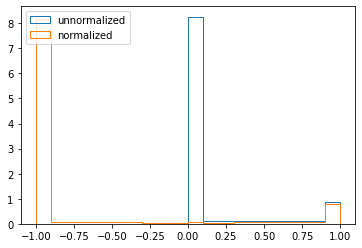

In [7]:
images_normalized, _ = next(iter(torch.utils.data.DataLoader(train_ds_normalized, shuffle=True, batch_size=6000)))
images_unnormal, _ = next(iter(torch.utils.data.DataLoader(train_ds_unnormalized, shuffle=True, batch_size=6000)))
print("shape_nor =", images_normalized.shape)
print("shape_unn =", images_unnormal.shape)
plt.hist(images_unnormal.numpy().reshape(-1), label="unnormalized", density=True, bins=10, histtype="step")
plt.hist(images_normalized.numpy().reshape(-1), label="normalized", density=True, bins=20, histtype="step")
plt.legend()
plt.show()
# plt.imshow(np.transpose(images[0], axes=(1,2,0)), cmap="gray")

In [42]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

model = Unet(
    dim = 64,
    dim_mults = (1,2,4),
    channels = 1
).to(device)

diffusion = GaussianDiffusion(
    model,
    objective = "pred_noise",
    image_size = 28,
    timesteps = 500,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

def plt_sampled_images(savefig="diffusion_epoch.png"):
    sampled_images = diffusion.sample(64).cpu()
    sampled_images = sampled_images.reshape(8,8,1,28,28)
    fig, ax = plt.subplots(8,8, figsize=(8,8), dpi=200, constrained_layout=True)
    fig.suptitle(f"epoch {epoch:03d}/{num_epochs:03d}; step {step:03d}")
    for i in range(8):
        for j in range(8):
            # ax = plt.subplot(4,4,i+1)
            ax[i][j].imshow(np.transpose(sampled_images[i][j], axes=(1,2,0)), 
    cmap = 'gray')
            ax[i][j].axis('off')
            # ax[i][j].set_xticks([])
            # ax[i][j].set_yticks([])
    # plt.tight_layout()
    if savefig != False:
        plt.savefig(savefig)
        plt.close()

In [43]:
num_epochs = 20
for epoch in range(num_epochs):
    start_time = time.time()
    for step, (mnist_images, mnist_labels) in enumerate(train_loader):
        mnist_images = mnist_images.to(device=device)
        optimizer.zero_grad()
        loss = diffusion(mnist_images).to(device)
        loss.backward()
        optimizer.step()
        # if epoch == 0 and step % 5 == 0:
        #     plt_sampled_images(f"diffusion_step{step:03d}.png")
    end_time = time.time()
    print(f"Epoch: {epoch}, {batch_size} batches, {step+1} steps, cost {end_time-start_time:.3f} sec, Loss.: {loss}")
    
    plt_sampled_images(f"diffusion_epoch{epoch:03d}.png")

torch.save(model.state_dict(), "diffusion.pt")


KeyboardInterrupt: 